# Transfer Learning in NLP

In this notebook, we will go through basics of Transfer Learning in NLP using two architectures (pretrained models) CoVe and BERT and also compare the results of custom embeddings on LSTM, BiLSTM, GRU with CoVe and BERT on [Twitter US Airline Sentiment dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

### Dataset

Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").  It contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines

---

Here we will use [fastai](https://docs.fast.ai/  "fastai Docs").


Everything is explained in-detail in [blog post](). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/tl_nlp/tl_nlp_fastai.ipynb)

### Approach


**ULMFiT**

1. **Finetune LM** : Use a pretrained language model (wikitext-103) to finetune pretrained LM on target data of tweets.

When this finetuned LM is given a seed of `The worst airline`, it produces the output, 2 sentences of 40 words each :

`The worst airline ever . By 2 / 28 , no other ramps . Unloaded . No food option . No catering . There are no seats in sight . Now , after 2 pm , no`

`The worst airline in the world , it dramatically nj would be great . xxbos @jetblue Ca n't find that it 's priority until Tuesday . They 're being treated like by multiple times in two years for " this`

This shows our finetuned LM has captured some semantics of our dataset.


2. **Finetune Classifier**: Use the finetuned LM model to predict the classes for classification of tweets into 3 classes using methods such as gradual freezing and slanted learning rates.


### Results



|  Approach | Epoch  | Time (min)  | Train loss |  Dev  | Dev Accuracy (%)  |
|---|---|---|---|---|---|
| Finetune LM | 15   |  6 | 3.575478 | 4.021957  | 0.264607 |
| Finetune Classifier | 5   |  2 | 0.786838  |	0.658620  | 0.724479 |
| Gradual Unfreezing (Last 1 layer) | 5   |  2 | 0.725324  |	0.590953  | 0.752134 |
| Gradual Unfreezing (Last 2 layer) | 5   |  3 | 0.556359  |	0.486604   | 0.812564 |
| Unfreeze whole and train | 8   |  7 |  0.474538  |	0.446159  | 0.829293 |

		
 	 		 	


## Twitter Sentiment Data


Code Adapted from: [Link](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb)

Paper ULMFiT: [Link](https://arxiv.org/pdf/1801.06146.pdf)

In [0]:
from fastai.text import *
from pathlib import Path

In [0]:
path = Path("/content")
df = pd.read_csv('https://query.data.world/s/hus7zihvuo5vt65cnv4fcfn2ppfj6y', encoding = "ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


In [0]:
data = df[['airline_sentiment', 'text']]
data.to_csv('tweets_sentiment.csv', index=False)

In [0]:
df['text'][1]

"@VirginAmerica plus you've added commercials to the experience... tacky."

Two Stages

Create a LM Model and fine tune the model using the pretrained model

Use the finetune model as classifier

### Language Model

In [0]:
#batch size
bs = 48

# datablock for language model
data_lm = TextLMDataBunch.from_csv(path, 'tweets_sentiment.csv')

In [0]:
data_lm.show_batch()

idx,text
0,"xxup xxunk xxup fll # flight today . $ 700 to switch . xxmaj no notice no apology . xxmaj we are done flying # unitedairlines . xxbos @virginamerica on ipad and iphone , clicking the xxup checkin link in the email i received at 24hrs before flight xxbos @united just changed again . xxmaj this is crazy ! # xxunk http : / / t.co / xxunk xxbos @usairways"
1,. # custserv xxbos @usairways this is the xxunk pilot . @americanair sure you want to merge with these xxunk hitting xxunk ? http : / / t.co / xxunk xxbos @americanair we have 8 ppl so we need 2 know how many seats are on the next flight . xxmaj plz put us on standby for 4 people on the next flight ? xxbos @americanair thanks so much !
2,n't even left xxup atl . xxmaj should have picked xxmaj delta maybe ? xxbos @united need assistance to change flight to get to an ailing parent .. \n have flight leaving xxmaj tuesday need to change xxup asap to sooner # custserv xxbos @southwestair xxmaj thanks . i 'll keep checking . i 'm trying to book our first xxmaj disney xxmaj world vacation . xxbos @united here
3,"@united well , you ca n't fix me missing my buddies 30th bday because of negligence but you can attempt to make up for it . xxbos @united volumes , profit up http : / / t.co / xxunk # aviation # xxunk http : / / t.co / xxunk xxbos @jetblue great job getting flight 28 in 10 minutes early . xxmaj too bad we 're at 50 minutes"
4,"xxmaj philadelphia airport never again will i fly with them ! _ xxup ù÷ _ xxbos @southwestair xxmaj customer relations line had busy signal too , called the normal line and the service rep thought i was dumb for not knowing . xxbos @virginamerica for all my flight stuff wrong and did nothing about it . xxmaj had # worst # flight ever xxbos @usairways @americanair u are the worst"


In [0]:
# #Since above step can be a bit time-consuming, it's best to save the result.
# #This will create a 'tmp' directory where all the computed stuff will be stored
# data_lm.save('data_lm_export.pkl')

In [0]:
# # then reload those results using load_data
# data_lm = load_data(path, fname='data_lm_export.pkl')

## Finetune pretrained model 

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on tweets isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01


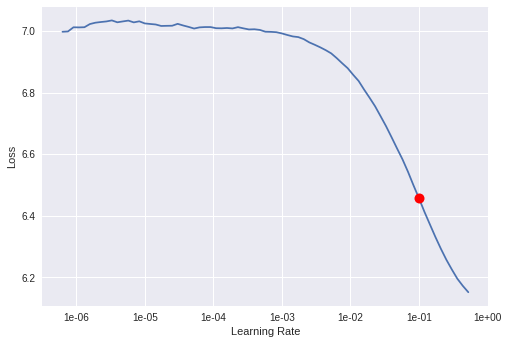

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(5, 1.20E-01, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.780935,4.186964,0.237012
2,4.556332,4.329750,0.232436
3,4.395356,4.209530,0.243736
4,4.096006,4.056077,0.259891
5,3.784350,4.024469,0.263770


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07


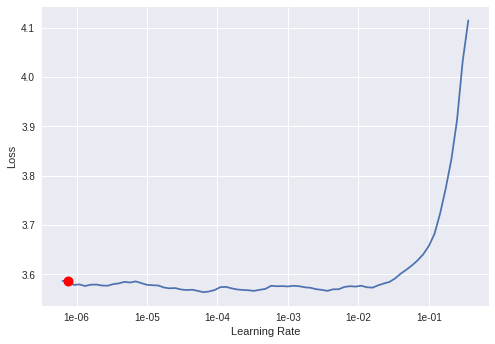

In [0]:
#unfreeze the model and fine-tune it

learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(10, 6.31E-07, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.572333,4.023167,0.264062
2,3.571411,4.023208,0.264174
3,3.568293,4.023170,0.264049
4,3.566987,4.022425,0.264314
5,3.569482,4.022603,0.263993
6,3.574756,4.022795,0.263979
7,3.565048,4.023178,0.263881
8,3.571816,4.023063,0.263756
9,3.575478,4.021957,0.264607
10,3.569856,4.021911,0.263951


Let's try to predict what has our language model learned from dataset by letting it generate the sentence which we saw in Char-RNN tutorial.

In [0]:
TEXT = "The worst airline"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The worst airline ever . By 2 / 28 , no other ramps . Unloaded . No food option . No catering . There are no seats in sight . Now , after 2 pm , no
The worst airline in the world , it dramatically nj would be great . xxbos @jetblue Ca n't find that it 's priority until Tuesday . They 're being treated like by multiple times in two years for " this


In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

In [0]:
# datablock for classifier

data_clas = TextClasDataBunch.from_csv(path, 'tweets_sentiment.csv', vocab=data_lm.train_ds.vocab, bs=32,
                                      text_cols='text', label_cols='airline_sentiment')

In [0]:
# data_clas.save('data_clas.pkl')

In [0]:
# data_cls = data_clas.load('data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup bein xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,negative
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp. xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @united xxmaj united xxmaj club team is xxup a+ & & got me a seat xxmaj late xxmaj flightr . xxmaj still , not sure why a last min xxup ual xxmaj cancelled xxmaj flightlation costs me $ yet overbooked folks get $ ?",negative
xxbos @southwestair xxmaj hi ! xxmaj just got my xxup tsa pre - check # & & put it in my acct . xxmaj but it 's not on my boarding pass for a flight this xxunk . xxmaj can it be updated ?,negative


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02


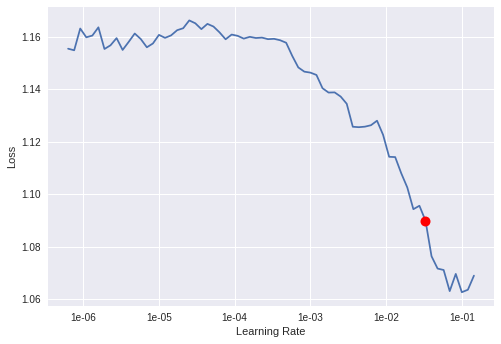

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(5, 2.75E-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.826510,0.727270,0.694435
2,0.831959,0.677368,0.715603
3,0.817753,0.698330,0.718334
4,0.781654,0.679023,0.718334
5,0.786838,0.658620,0.724479


### Gradual Unfreezing

In [0]:
#unfreeze last 1 layer and train
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.765062,0.644949,0.730966
2,0.735334,0.618762,0.742916
3,0.729768,0.604187,0.744623
4,0.716741,0.591191,0.754865
5,0.725324,0.590953,0.752134


In [0]:
#unfreeze last 2 layers and train
learn.freeze_to(-3)
learn.fit_one_cycle(5, slice(5e-3/(2.6**4), 5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.699117,0.561120,0.774326
2,0.642854,0.890200,0.784568
3,0.601090,0.673197,0.794469
4,0.561896,0.498641,0.813930
5,0.556359,0.486604,0.812564


In [0]:
learn.save('3_unfreeze')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-04


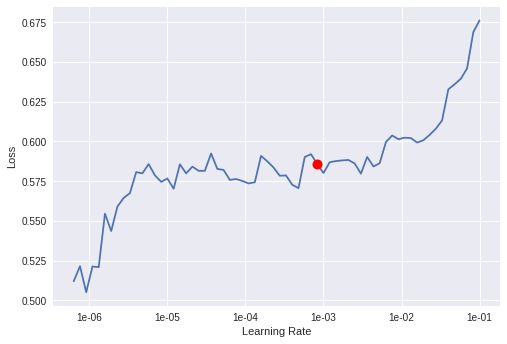

In [0]:
#unfreeze whole model and train
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(8, slice(1e-4/2*(2.6**4), 1e-4/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.522395,0.530417,0.813930
2,0.543465,0.490725,0.818027
3,0.526981,0.468678,0.831342
4,0.518565,0.440695,0.828952
5,0.484885,0.438958,0.827586
6,0.437532,0.436084,0.829976
7,0.457774,0.437971,0.833049
8,0.474538,0.446159,0.829293


## Prediction

In [0]:
learn.predict("The service of Spirt Airways stinks!")

(Category negative, tensor(0), tensor([0.6030, 0.0828, 0.3142]))

In [0]:
learn.predict("Bloody plane is delayed again. An hour delay Sort it out #QANTAS")

(Category negative, tensor(0), tensor([0.9970, 0.0012, 0.0018]))

In [0]:
learn.predict("Woohoo! 4 hour flight delay. I love travel.")

(Category negative, tensor(0), tensor([0.6910, 0.0140, 0.2950]))

In [0]:
learn.predict("The food in this American Airlines flight from Paris is terrible. It's an affront to the destination this plane is coming from!")

(Category negative, tensor(0), tensor([0.8682, 0.0721, 0.0597]))

In [0]:
learn.predict("Thank you @AirFrance for my cancelled flight, now I have to take the train to #Nantes. #Travel #France #PilotStrike")

(Category positive, tensor(2), tensor([0.3579, 0.1216, 0.5205]))